In [65]:
"""
Requirements:
  pip install numpy pandas scikit-learn matplotlib joblib

What it does:
  - Loads 'Classification_input.csv' (first column 'label')
  - Strong baseline: SelectKBest + Elastic-Net multinomial logistic regression
  - 5-fold stratified CV with out-of-sample predictions
  - Saves:
      outputs/confusion_matrix.png
      outputs/predictions.csv
      outputs/best_model.joblib
  - Optional: Factorized decoder (Consonant 4-way × Vowel 3-way) with probability-combination
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from joblib import dump
import argparse
import statistics
import seaborn as sns


In [2]:

# -----------------------------
# 0) Paths and basic settings
# -----------------------------
CSV_PATH = "../Classification_input.csv"   # change if needed
OUT_DIR  = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42

In [3]:
# -----------------------------
# 1) Load data
# -----------------------------
df = pd.read_csv(CSV_PATH)

# Find label column robustly
label_col_candidates = [c for c in df.columns if str(c).strip().lower() == "label"]
label_col = label_col_candidates[0] if label_col_candidates else df.columns[0]

y_raw = df[label_col].values
X_df  = df.drop(columns=[label_col])

# Encode labels to 0..K-1 (keep original names)
y_cat = pd.Categorical(y_raw)
y     = y_cat.codes
class_names = list(map(str, y_cat.categories))

# Coerce features to numeric (NaNs are imputed later)
X_df = X_df.apply(pd.to_numeric, errors="coerce")
X    = X_df.values

n_samples, n_features = X.shape
n_classes = len(class_names)

print(f"Data: {n_samples} samples, {n_features} features, {n_classes} classes")
print("Label mapping (id -> original):")
print({i: class_names[i] for i in range(n_classes)})

# Class balance (just to eyeball)
counts = pd.Series(y).value_counts().sort_index()
print("\nClass counts per label:")
print(pd.DataFrame({"id": range(n_classes), "label": class_names, "count": counts.values}))


Data: 180 samples, 2001 features, 12 classes
Label mapping (id -> original):
{0: 'ghah', 1: 'ghee', 2: 'ghoo', 3: 'sah', 4: 'see', 5: 'soo', 6: 'tah', 7: 'tee', 8: 'too', 9: 'vah', 10: 'vee', 11: 'voo'}

Class counts per label:
    id label  count
0    0  ghah     15
1    1  ghee     15
2    2  ghoo     15
3    3   sah     15
4    4   see     15
5    5   soo     15
6    6   tah     15
7    7   tee     15
8    8   too     15
9    9   vah     15
10  10   vee     15
11  11   voo     15



=== Baseline (12-way) | 5-fold out-of-sample performance ===
Accuracy:          0.411
Balanced accuracy: 0.411
F1 macro:          0.407

Per-class report:
              precision    recall  f1-score   support

        ghah      0.600     0.600     0.600        15
        ghee      0.500     0.667     0.571        15
        ghoo      0.350     0.467     0.400        15
         sah      0.357     0.333     0.345        15
         see      0.312     0.333     0.323        15
         soo      0.417     0.333     0.370        15
         tah      0.231     0.200     0.214        15
         tee      0.333     0.400     0.364        15
         too      0.538     0.467     0.500        15
         vah      0.455     0.333     0.385        15
         vee      0.333     0.267     0.296        15
         voo      0.500     0.533     0.516        15

    accuracy                          0.411       180
   macro avg      0.411     0.411     0.407       180
weighted avg      0.411     0.41

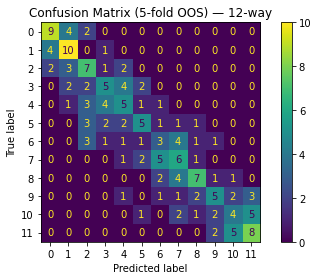

In [4]:
# -----------------------------
# 2) Strong baseline decoder
# -----------------------------
# Why this works well here:
# - Impute missing values (median) -> robust to NaNs
# - Standardize -> needed for linear models and ANOVA scores
# - SelectKBest(f_classif) -> reduce dimension to the most discriminative time bins
# - Elastic-Net multinomial logistic -> strong, sparse-ish, handles correlated features
#
# NOTE: k_keep=200 is a good starting point for ~2k features and ~180 samples.
#       You can try 100 or 300 if you want to tune—it trades bias/variance.
k_keep = min(200, n_features)

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=k_keep)),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="elasticnet",
        multi_class="multinomial",
        max_iter=4000,
        C=1.0,           # reasonable default
        l1_ratio=0.5,    # mix of L1/L2
        random_state=RANDOM_STATE
    ))
])

# Out-of-sample predictions via 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
y_pred_oos = cross_val_predict(pipe, X, y, cv=cv, method="predict", n_jobs=-1)

acc  = accuracy_score(y, y_pred_oos)
bacc = balanced_accuracy_score(y, y_pred_oos)
f1m  = f1_score(y, y_pred_oos, average="macro")

print("\n=== Baseline (12-way) | 5-fold out-of-sample performance ===")
print(f"Accuracy:          {acc:.3f}")
print(f"Balanced accuracy: {bacc:.3f}")
print(f"F1 macro:          {f1m:.3f}")
print("\nPer-class report:")
print(classification_report(y, y_pred_oos, target_names=class_names, digits=3, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y, y_pred_oos)
fig = plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(n_classes)])
disp.plot(values_format='d')
plt.title("Confusion Matrix (5-fold OOS) — 12-way")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix_12way.png")
plt.savefig(cm_path, dpi=150)
plt.close(fig)
print(f"Saved confusion matrix → {cm_path}")

In [11]:
acc_all = []

for item in range (20):
    k_keep = min(200, n_features)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_classif, k=k_keep)),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            multi_class="multinomial",
            max_iter=4000,
            C=1.0,           # reasonable default
            l1_ratio=0.5     # mix of L1/L2
        ))
    ])

    # Out-of-sample predictions via 5-fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    y_pred_oos = cross_val_predict(pipe, X, y, cv=cv, method="predict", n_jobs=-1)

    acc  = accuracy_score(y, y_pred_oos)
    acc_all.append(acc)
    
acc_all

[0.4166666666666667,
 0.4,
 0.4166666666666667,
 0.43333333333333335,
 0.37777777777777777,
 0.39444444444444443,
 0.42777777777777776,
 0.34444444444444444,
 0.40555555555555556,
 0.3611111111111111,
 0.37777777777777777,
 0.40555555555555556,
 0.37777777777777777,
 0.4166666666666667,
 0.4444444444444444,
 0.39444444444444443,
 0.45555555555555555,
 0.34444444444444444,
 0.43333333333333335,
 0.4166666666666667]

In [12]:
statistics.stdev(acc_all)

0.031083948041729655

In [ ]:
# -----------------------------
# 3) (Optional) Factorized decoder: C×V
# -----------------------------
# If each unit tends to encode *either* consonant or vowel, a flat 12-way model
# can struggle. A common trick: decode consonant (4-way) and vowel (3-way)
# separately, then combine probabilities: P(CV)=P(C)*P(V).
#
# We'll derive C and V from your label strings:
#   consonant = first character (g/s/t/v)
#   vowel     = last two letters (ah/ee/oo)
# Adjust the parsing if your labels change.
def split_cv_labels(names):
    cons_map = {}
    vow_map  = {}
    yC = []
    yV = []
    for name in names:
        # Conservative parsing
        c = name[0].lower()
        v = name[-2:].lower()
        if c not in cons_map:
            cons_map[c] = len(cons_map)
        if v not in vow_map:
            vow_map[v] = len(vow_map)
        yC.append(cons_map[c])
        yV.append(vow_map[v])
    inv_cons = {v:k for k,v in cons_map.items()}
    inv_vow  = {v:k for k,v in vow_map.items()}
    return np.array(yC), np.array(yV), inv_cons, inv_vow

yC, yV, inv_cons, inv_vow = split_cv_labels(class_names)
nC, nV = len(inv_cons), len(inv_vow)
print(f"\nDetected consonants ({nC}):", inv_cons)
print("Detected vowels     ({nV}):", inv_vow)

# Expand trial-wise C/V targets from the class id y
y_trial_C = yC[y]  # map each trial's class id to its consonant id
y_trial_V = yV[y]  # map to vowel id

# Two separate models (same pipeline shape), get OOS probabilities
def oos_proba(pipe, X, y, cv):
    # cross_val_predict with method='predict_proba' works for LogisticRegression
    return cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)


Detected consonants (4): {0: 'g', 1: 's', 2: 't', 3: 'v'}
Detected vowels     ({nV}): {0: 'ah', 1: 'ee', 2: 'oo'}

=== Factorized (C×V) | 5-fold out-of-sample performance ===
Accuracy:          0.322
Balanced accuracy: 0.322
F1 macro:          0.312
Saved factorized confusion matrix → outputs/confusion_matrix_CxV.png

=== Ensemble (12-way + C×V) | 5-fold OOS ===
Accuracy:          0.411
Balanced accuracy: 0.411
F1 macro:          0.405

Wrote summary → outputs/summary.txt


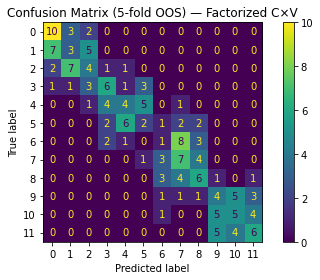

In [10]:
pipe_C = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=k_keep)),
    ("clf", LogisticRegression(
        solver="saga", penalty="elasticnet", multi_class="multinomial",
        max_iter=4000, C=1.0, l1_ratio=0.5, random_state=RANDOM_STATE))
])

pipe_V = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=k_keep)),
    ("clf", LogisticRegression(
        solver="saga", penalty="elasticnet", multi_class="multinomial",
        max_iter=4000, C=1.0, l1_ratio=0.5, random_state=RANDOM_STATE))
])

pC = oos_proba(pipe_C, X, y_trial_C, cv)
pV = oos_proba(pipe_V, X, y_trial_V, cv)

# Combine probs under independence: P(CV)=P(C)*P(V)
pCV = np.einsum('ij,ik->ijk', pC, pV).reshape(len(X), nC*nV)
y_pred_fac = pCV.argmax(axis=1)

acc_fac  = accuracy_score(y, y_pred_fac)
bacc_fac = balanced_accuracy_score(y, y_pred_fac)
f1m_fac  = f1_score(y, y_pred_fac, average="macro")

print("\n=== Factorized (C×V) | 5-fold out-of-sample performance ===")
print(f"Accuracy:          {acc_fac:.3f}")
print(f"Balanced accuracy: {bacc_fac:.3f}")
print(f"F1 macro:          {f1m_fac:.3f}")

cm_fac = confusion_matrix(y, y_pred_fac)
fig = plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm_fac, display_labels=[str(i) for i in range(n_classes)]).plot(values_format='d')
plt.title("Confusion Matrix (5-fold OOS) — Factorized C×V")
plt.tight_layout()
cm_fac_path = os.path.join(OUT_DIR, "confusion_matrix_CxV.png")
plt.savefig(cm_fac_path, dpi=150)
plt.close(fig)
print(f"Saved factorized confusion matrix → {cm_fac_path}")

# Optional: simple ensemble of the two approaches (average probabilities)
# For that, also get baseline 12-way probabilities:
pipe_prob12 = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=k_keep)),
    ("clf", LogisticRegression(
        solver="saga", penalty="elasticnet", multi_class="multinomial",
        max_iter=4000, C=1.0, l1_ratio=0.5, random_state=RANDOM_STATE))
])
p12 = cross_val_predict(pipe_prob12, X, y, cv=cv, method="predict_proba", n_jobs=-1)

# Ensemble: average 12-way probs with factorized probs
p_ens = 0.5 * p12 + 0.5 * pCV
y_pred_ens = p_ens.argmax(axis=1)
acc_ens  = accuracy_score(y, y_pred_ens)
bacc_ens = balanced_accuracy_score(y, y_pred_ens)
f1m_ens  = f1_score(y, y_pred_ens, average="macro")

print("\n=== Ensemble (12-way + C×V) | 5-fold OOS ===")
print(f"Accuracy:          {acc_ens:.3f}")
print(f"Balanced accuracy: {bacc_ens:.3f}")
print(f"F1 macro:          {f1m_ens:.3f}")

# Save final comparison
with open(os.path.join(OUT_DIR, "summary.txt"), "w") as f:
    f.write("Baseline 12-way:\n")
    f.write(f"  Acc={acc:.3f}, BAcc={bacc:.3f}, F1m={f1m:.3f}\n")
    f.write("Factorized C×V:\n")
    f.write(f"  Acc={acc_fac:.3f}, BAcc={bacc_fac:.3f}, F1m={f1m_fac:.3f}\n")
    f.write("Ensemble (avg probs):\n")
    f.write(f"  Acc={acc_ens:.3f}, BAcc={bacc_ens:.3f}, F1m={f1m_ens:.3f}\n")

print(f"\nWrote summary → {os.path.join(OUT_DIR, 'summary.txt')}")

In [13]:
acc_fac_all = []

for item in range (20):
    
    pipe_C = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_classif, k=k_keep)),
        ("clf", LogisticRegression(
            solver="saga", penalty="elasticnet", multi_class="multinomial",
            max_iter=4000, C=1.0, l1_ratio=0.5))
    ])

    pipe_V = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_classif, k=k_keep)),
        ("clf", LogisticRegression(
            solver="saga", penalty="elasticnet", multi_class="multinomial",
            max_iter=4000, C=1.0, l1_ratio=0.5))
    ])

    pC = oos_proba(pipe_C, X, y_trial_C, cv)
    pV = oos_proba(pipe_V, X, y_trial_V, cv)

    # Combine probs under independence: P(CV)=P(C)*P(V)
    pCV = np.einsum('ij,ik->ijk', pC, pV).reshape(len(X), nC*nV)
    y_pred_fac = pCV.argmax(axis=1)

    acc_fac  = accuracy_score(y, y_pred_fac)
    acc_fac_all.append(acc_fac)

In [16]:
acc_fac_all

[0.37222222222222223,
 0.4,
 0.35,
 0.3888888888888889,
 0.35555555555555557,
 0.3611111111111111,
 0.4,
 0.3111111111111111,
 0.37222222222222223,
 0.4,
 0.37222222222222223,
 0.37222222222222223,
 0.42777777777777776,
 0.37777777777777777,
 0.37222222222222223,
 0.36666666666666664,
 0.4,
 0.3277777777777778,
 0.35555555555555557,
 0.34444444444444444]

In [17]:

def parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument("--csv", type=str, default=CSV_PATH, help="Path to input CSV")
    ap.add_argument("--outdir", type=str, default="outputs", help="Output directory")
    ap.add_argument("--splits", type=int, default=5, help="Stratified K-fold splits")
    ap.add_argument("--k_keep", type=int, default=150, help="SelectKBest features per unit (<=200)")
    ap.add_argument("--C", type=float, default=1.0, help="LogReg regularization strength (C)")
    ap.add_argument("--l1", type=float, default=0.5, help="Elastic-net l1_ratio [0..1]")
    ap.add_argument("--max_iter", type=int, default=3000, help="Max iterations for LogReg")
    ap.add_argument("--tol", type=float, default=1e-3, help="Tolerance for LogReg convergence")
    ap.add_argument("--random_state", type=int, default=42, help="Random seed")
    ap.add_argument('-f')

    return ap.parse_args()

def load_data(csv_path):
    df = pd.read_csv(csv_path)

    # Label column
    label_cols = [c for c in df.columns if str(c).strip().lower() == "label"]
    label_col = label_cols[0] if label_cols else df.columns[0]

    y_raw = df[label_col].values
    X_df = df.drop(columns=[label_col])

    # Drop any 'Unnamed:*' columns
    extra_cols = [c for c in X_df.columns if str(c).lower().startswith("unnamed")]
    if extra_cols:
        X_df = X_df.drop(columns=extra_cols)

    # Coerce to numeric
    X_df = X_df.apply(pd.to_numeric, errors="coerce")
    X = X_df.values

    # Encode labels 0..K-1
    y_cat = pd.Categorical(y_raw)
    y = y_cat.codes
    class_names = list(map(str, y_cat.categories))
    return X, y, class_names

def ensure_unit_layout(X, features_per_unit=200):
    n_features = X.shape[1]
    if n_features % features_per_unit != 0:
        raise ValueError(
            f"Expected feature columns to be a multiple of {features_per_unit}, "
            f"but got {n_features}. Check your CSV (or drop extra columns)."
        )
    n_units = n_features // features_per_unit
    return n_units

def make_pipe(k_keep, C, l1_ratio, max_iter, tol, random_state):
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_classif, k=k_keep)),
        ("clf", LogisticRegression(
            solver="saga",
            penalty="elasticnet",
            multi_class="multinomial",
            C=C,
            l1_ratio=l1_ratio,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state
        ))
    ])

def split_cv_labels(class_names):
    """
    Parse consonant as first character, vowel as last two letters.
    Returns:
      yC_from_class: length-K array mapping class_id -> consonant_id
      yV_from_class: length-K array mapping class_id -> vowel_id
      inv_cons, inv_vow: id->string maps
    """
    cons_map, vow_map = {}, {}
    yC_ids, yV_ids = [], []
    for name in class_names:
        c = name[0].lower()
        v = name[-2:].lower()
        if c not in cons_map:
            cons_map[c] = len(cons_map)
        if v not in vow_map:
            vow_map[v] = len(vow_map)
        yC_ids.append(cons_map[c])
        yV_ids.append(vow_map[v])

    inv_cons = {v: k for k, v in cons_map.items()}
    inv_vow  = {v: k for k, v in vow_map.items()}
    return np.array(yC_ids), np.array(yV_ids), inv_cons, inv_vow

def evaluate_unit(
    X_unit, y, splits, yC_from_class, yV_from_class, pair_to_class,
    k_keep, C, l1_ratio, max_iter, tol, random_state
):
    """
    Returns per-fold accuracies:
      fold_acc_12:  12-way accuracies per fold
      fold_acc_CV:  factorized C×V accuracies per fold
    """
    k_eff = min(k_keep, X_unit.shape[1])

    pipe12 = make_pipe(k_eff, C, l1_ratio, max_iter, tol, random_state)
    pipeC  = make_pipe(k_eff, C, l1_ratio, max_iter, tol, random_state)
    pipeV  = make_pipe(k_eff, C, l1_ratio, max_iter, tol, random_state)

    yC = yC_from_class[y]
    yV = yV_from_class[y]

    fold_acc_12, fold_acc_CV = [], []

    for tr_idx, te_idx in splits:
        Xtr, Xte = X_unit[tr_idx], X_unit[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # 12-way
        pipe12.fit(Xtr, ytr)
        yhat12 = pipe12.predict(Xte)
        fold_acc_12.append(accuracy_score(yte, yhat12))

        # Factorized: fit C- and V-heads
        pipeC.fit(Xtr, yC[tr_idx])
        pipeV.fit(Xtr, yV[tr_idx])

        pC_raw = pipeC.predict_proba(Xte)
        pV_raw = pipeV.predict_proba(Xte)

        # Align to fixed class index sets [0..nC-1] and [0..nV-1]
        nC = len(np.unique(yC))
        nV = len(np.unique(yV))
        pC = np.zeros((len(te_idx), nC))
        pV = np.zeros((len(te_idx), nV))

        for j, c_id in enumerate(pipeC.named_steps["clf"].classes_):
            pC[:, int(c_id)] = pC_raw[:, j]
        for j, v_id in enumerate(pipeV.named_steps["clf"].classes_):
            pV[:, int(v_id)] = pV_raw[:, j]

        # Combine probabilities per test sample: P(CV) = P(C)*P(V)
        yhat_fac = np.empty(len(te_idx), dtype=int)
        for i_row in range(len(te_idx)):
            M = np.outer(pC[i_row], pV[i_row])  # (nC, nV)
            c_hat, v_hat = np.unravel_index(np.argmax(M), M.shape)
            yhat_fac[i_row] = pair_to_class[(int(c_hat), int(v_hat))]

        fold_acc_CV.append(accuracy_score(yte, yhat_fac))

    return np.array(fold_acc_12), np.array(fold_acc_CV)

In [19]:
args = parse_args()
os.makedirs(args.outdir, exist_ok=True)
args.csv = CSV_PATH

print(f"Loading: {args.csv}")
X, y, class_names = load_data(args.csv)
n_samples, n_features = X.shape
print(f"Data: {n_samples} samples, {n_features} features, {len(class_names)} classes")

n_units = ensure_unit_layout(X, features_per_unit=200)
print(f"Detected {n_units} units (200 features each).")

# Build maps for factorized decoding
yC_from_class, yV_from_class, inv_cons, inv_vow = split_cv_labels(class_names)
pair_to_class = {(yC_from_class[i], yV_from_class[i]): i for i in range(len(class_names))}

# CV splits (shared across units)
skf = StratifiedKFold(n_splits=args.splits, shuffle=True, random_state=args.random_state)
splits = list(skf.split(X, y))

per_unit_rows = []
per_unit_fold_rows = []

for unit_idx in range(n_units):
    s, e = unit_idx * 200, (unit_idx + 1) * 200
    X_unit = X[:, s:e]
    print(f"\nUnit {unit_idx+1}: evaluating on features [{s}:{e})")

    fold_acc_12, fold_acc_CV = evaluate_unit(
        X_unit, y, splits,
        yC_from_class, yV_from_class, pair_to_class,
        args.k_keep, args.C, args.l1, args.max_iter, args.tol, args.random_state
    )

    per_unit_rows.append({
        "unit": unit_idx + 1,
        "acc_12way_mean": float(fold_acc_12.mean()),
        "acc_12way_std": float(fold_acc_12.std(ddof=1)),
        "acc_CxV_mean": float(fold_acc_CV.mean()),
        "acc_CxV_std": float(fold_acc_CV.std(ddof=1)),
    })

    for f_idx, (a12, aCV) in enumerate(zip(fold_acc_12, fold_acc_CV), start=1):
        per_unit_fold_rows.append({
            "unit": unit_idx + 1,
            "fold": f_idx,
            "acc_12way": float(a12),
            "acc_CxV": float(aCV),
        })

per_unit_df = pd.DataFrame(per_unit_rows)
per_unit_fold_df = pd.DataFrame(per_unit_fold_rows)

per_unit_csv = os.path.join(args.outdir, "per_unit_accuracies.csv")
per_unit_fold_csv = os.path.join(args.outdir, "per_unit_fold_accuracies.csv")
per_unit_df.to_csv(per_unit_csv, index=False)
per_unit_fold_df.to_csv(per_unit_fold_csv, index=False)
print("\nSaved per-unit summary →", per_unit_csv)
print("Saved per-unit per-fold →", per_unit_fold_csv)

Loading: ../Classification_input.csv
Data: 180 samples, 2000 features, 12 classes
Detected 10 units (200 features each).

Unit 1: evaluating on features [0:200)

Unit 2: evaluating on features [200:400)

Unit 3: evaluating on features [400:600)

Unit 4: evaluating on features [600:800)

Unit 5: evaluating on features [800:1000)

Unit 6: evaluating on features [1000:1200)

Unit 7: evaluating on features [1200:1400)

Unit 8: evaluating on features [1400:1600)

Unit 9: evaluating on features [1600:1800)

Unit 10: evaluating on features [1800:2000)

Saved per-unit summary → outputs/per_unit_accuracies.csv
Saved per-unit per-fold → outputs/per_unit_fold_accuracies.csv


In [59]:
units = per_unit_df["unit"].values
units_com = np.append('Combined', units)

means_12 = per_unit_df["acc_12way_mean"].values
means_12_com = np.append(np.mean(acc_all), means_12)

stds_12  = per_unit_df["acc_12way_std"].values
stds_12_com = np.append(statistics.stdev(acc_all), stds_12)

means_CV = per_unit_df["acc_CxV_mean"].values
means_CV_com = np.append(np.mean(acc_fac_all), means_CV)

stds_CV  = per_unit_df["acc_CxV_std"].values
stds_CV_com = np.append(statistics.stdev(acc_fac_all), stds_CV)

x = np.arange(len(units)+1)
width = 0.35

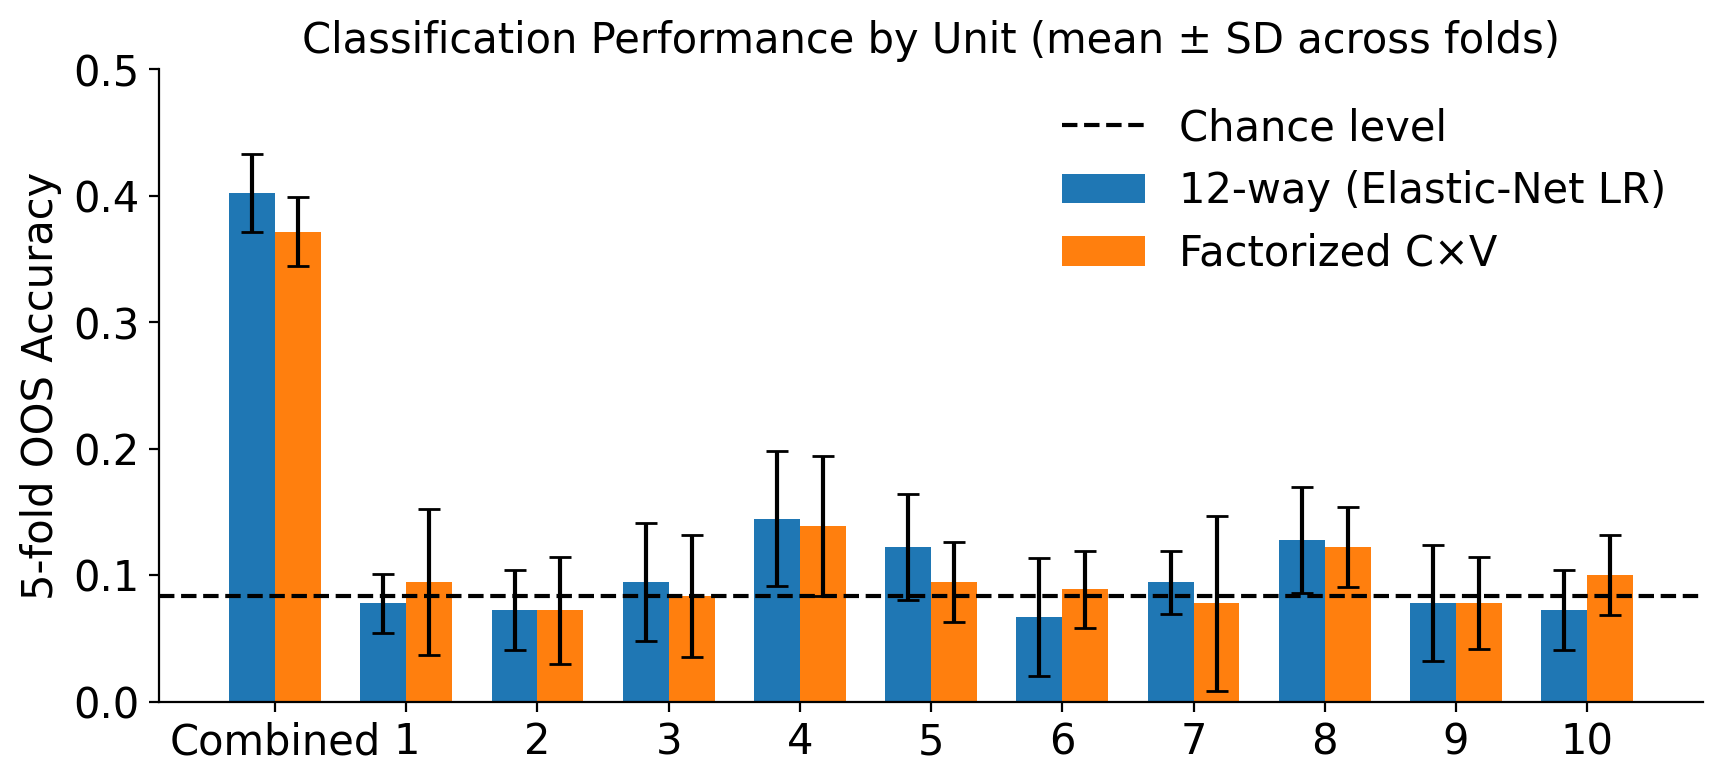

In [66]:

fig, axs = plt.subplots(1, 1, figsize=(8.5, 3.8), dpi=200, constrained_layout=True)
axs.bar(x - width/2, means_12_com, width, yerr=stds_12_com, 
       capsize=4, label="12-way (Elastic-Net LR)")
axs.bar(x + width/2, means_CV_com, width, yerr=stds_CV_com, 
       capsize=4, label="Factorized C×V")

axs.set_xticks(np.linspace(0, 10, 11))
axs.set_xticklabels([str(u) for u in units_com], fontsize=15, rotation=0.0)
#axs.set_xlabel("Unit")
axs.set_ylabel("5-fold OOS Accuracy", fontsize=15)
axs.set_title("Classification Performance by Unit (mean ± SD across folds)", fontsize=15)
axs.set_ylim(0.0, 0.5)
# Chance line for 12 classes
axs.axhline(1.0 / len(class_names), linestyle="--", label='Chance level', color='k')
axs.legend(fontsize=15, frameon=0)
axs.set_yticks(axs.get_yticks())
axs.set_yticklabels(np.linspace(0, 5, 6)/10, fontsize=15)
sns.despine(ax=axs,
    top=True,
    right=True,
    left=False,
    bottom=False)
#plot_path = os.path.join(args.outdir, "unit_accuracy_comparison.png")
#plt.savefig(plot_path, dpi=150)
#plt.close(fig)
plt.plot();

In [ ]:
statistics.stdev(acc_all)